## waterstandstatistiek op basis vanuit waterstanden opgeslagen in his-bestanden

Deze notebook bevat informatie hoe het mogelijk is om .his-bestanden uit te lezen binnen Python en op welke manier hieruit waterstandstatistiek af te leiden is. Een aantal functies worden hierbij toegelicht. Waarbij elke functie in detail is beschreven in de toebehorende `docstring`. 

Allereerst importeren we de extension package.

In [1]:
import hkvsobekpy as hkv
import geopandas as gpd

Ook bepalen we de input bestanden.

In [2]:
his_file = r'input_data\waterstand-statistiek\CALCPNT.HIS'
shp_file = r'input_data\waterstand-statistiek\input_locaties.shp'

Informatie in het his-bestand kunnen we op de volgende manier inlezen. De metadata wordt weggeschreven binnen het object.

In [3]:
reflow = hkv.read_his.LeesMetadata(his_file)

De volgende drie functies kunnen gebruikt worden om de locaties, tijdstappen en parameters vanuit het .his bestand uit te lezen

In [4]:
locaties = reflow.KrijgLokaties()
tijdstappen = reflow.KrijgTijdstappen()
parameters = reflow.KrijgParameters()

In [5]:
print("""\
eerste 5 locaties:     {0}
laatste 2 tijdstappen: {1}
alle parameters:       {2}""".format(locaties[0:5],
                                     tijdstappen[-2:],
                                     parameters))

eerste 5 locaties:     ['1', '126', '11', '8', '14']
laatste 2 tijdstappen: [datetime.datetime(2014, 10, 18, 15, 20), datetime.datetime(2014, 12, 12, 10, 20)]
alle parameters:       ['Waterlevel max. (m A', 'Waterdepth max. (m) ']


Naast het .his-bestand is er een .shp-bestand gedefinieerd met een bijbehorende .dbf-bestand. De locaties die hierin staan gedefinieerd worden gebruikt voor als locaties vanuit het .his-bestand. 
Het is daarom van belang dat deze IDs identiek zijn. 

De shp-file kunnen we als volgt inlezen naar een `GeoDataFrame` en vervolgens plotten in figuur (de `shp`) en tabel (de `dbf`)

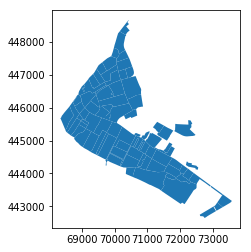

In [6]:
gdf = gpd.read_file(shp_file)
gdf.plot()

In [7]:
gdf.head()

,nodeID,OBJECTID_1,GPG_ID,GPGIDENT,GPGSTATUSV,SOORT_L,geometry
0,1,1,5265,GPG2010WBK III,vigerend definitief,aan- en afvoerpeilgebied,"POLYGON ((70808.0879999996 446403.7630000025, ..."
1,126,2,5266,GPG2010WBK I,vigerend definitief,aan- en afvoerpeilgebied,"POLYGON ((70401.89530000088 446904.1009999979,..."
2,11,3,5267,GPG2010WBK II,vigerend definitief,aan- en afvoerpeilgebied,"POLYGON ((69978.51000000164 447823.5369999995,..."
3,8,4,32787,GPG2008SDN III,vigerend definitief,aan- en afvoerpeilgebied,"POLYGON ((73277.05000000076 443333.6780000009,..."
4,14,5,2226,GPG2008SDN V,vigerend definitief,aan- en afvoerpeilgebied,"POLYGON ((70558.57000000034 443891.4620000034,..."


In dit geval zijn een aantal kolommen gedefinieerd met als laatste kolom een `nodeID` kolom. Deze IDs komen overeen met de locaties welke bekend zijn binnen het .his-bestand en gebruikt zullen worden om de waterstandstatistiek op te bepalen.

In het volgend code block vragen we met de `EnkeleWaardenArray` functie de waarden op van een enkele locatie en parameter en plotten we het resultaat gelijk terug vanuit het dataframe. Let op: `df_enkel` is een dataframe met een multi-column met locatie en parameter.

Het is mogelijk om met de functie `EnkeleWaardenArray` alleen de gebeurtenissen van een jaarlijkse terugkerende periode te selecteren, bijvoorbeeld om alleen de gebeurtenissen in de zomer of het groeizoen mee te nemen. Ook kunnen de jaarmaxima bepaald worden in het geval er meerdere gebeurtenissen in 1 jaar zitten, waarbij aangegeven kan worden of je de exacte datum terug wilt hebben of alleen het jaar met de maxima.

Met `startMMdd` wordt de start van de periode bepaald. Met `endMMdd` wordt de eind datum van de periode bepaald. Met `jaarmax_ax` is het mogelijk om de DataFrame te groeperen op basis van jaar om het jaarmaxima te bepalen. Het jaarmaxima wordt bepaald nadat de slice van de jaarlijkse periode is toegepast. Keuze bestaat uit:
- `'date'` - bepaalt de jaarlijkse maxima binnen de periode en geeft de maximale waarde terug met de exacte datum van deze gebeurtenis
- `'year'` - bepaalt de jaarlijkse maxima binnen de periode en geeft de maximale waarde terug met het jaar van de gebeurtenis
- `'none'` - retourneert alle gebeurtenissen in elk jaar welke binnen de periode filter vallen

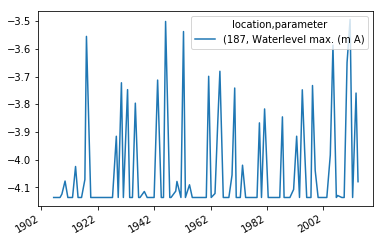

In [8]:
df_enkel = reflow.EnkeleWaardenArray(
    location = '187',
    parameter = 'Waterlevel max. (m A',
    startMMdd=(1, 1),
    endMMdd=(12, 31),
    jaarmax_as='date')
df_enkel.plot(legend=True)

Om de eerste 5 items te tonen gebruiken we de `.head()` functionaleit op de DataFrame van `df_enkel`. Te zien is dat in elk jaar de jaarmaxima al bepaald is en dat deze jaarmaxima gekoppeld is aan de unieke datum waar deze op plaatsvond. 

In [9]:
df_enkel.head()

location,187
parameter,Waterlevel max. (m A
1906-05-22 00:00:00,-4.136388
1907-04-26 20:00:00,-4.136388
1908-08-23 22:00:00,-4.136388
1909-04-24 22:00:00,-4.123895
1910-06-05 03:00:00,-4.077080


Soortgelijk kunnen we ook verschillende locaties voor een enkele parameter opvragen met de `MultiWaardenArray` functie. Standaard wordt een periode van `01-01` tot `12-31` in ogenschouw genomen, waarbij er een 1 jaarmaxima wordt 
bepaald welke met de specifieke datum van deze gebeurtenis. 
Om een jaarlijkse periode filter van 15 mei tot 15 oktober te gebruiken en de jaarmaxima als alleen jaar waarden terug te geven doe als volgt:

In [10]:
print(gdf['nodeID'].iloc[15:20].values)
print(parameters[0:1])

['CFBerg_IV_o' '1095' 'CFBerg_IV_20' '61' '165']
['Waterlevel max. (m A']


Text(0,0.5,'Waterlevel max. (m A')

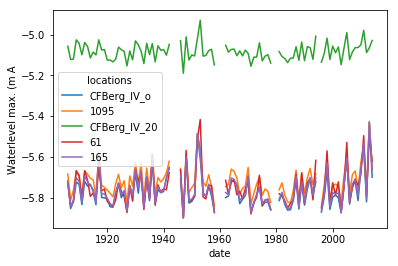

In [11]:
#Gebruik van MultiwaardenArray
df_multi = reflow.MultiWaardenArray(
    locations = ['CFBerg_IV_o', '1095', 'CFBerg_IV_20', '61', '165'],
    parameters = ['Waterlevel max. (m A'],
    startMMdd=(5,15),
    endMMdd=(10,15),
    jaarmax_as='year',
    drop_lege_jaren=False)
ax = df_multi.loc[:,'Waterlevel max. (m A'].plot()
ax.set_ylabel('Waterlevel max. (m A')

Voor `df_multi` is te zien dat de er voor elk jaar wel een jaarmaxima bepaald wordt binnen de filter, maar dat deze gekoppeld is aan alleen het jaar en niet de preciese datum van gebeurtenis. Deze kan namelijk verschillen van locatie tot locatie. Ook is te zien dat wanneer er geen gebeurtenissen zijn voor de periode filter deze gedropt kunnen worden uit de selectie. In dit voorbeeld is dat 1995. Wanneer je deze jaren niet dropt, zullen er `NaN` waarden getoond worden.

In [12]:
df_multi.head()

parameters Waterlevel max. (m A                                           
locations           CFBerg_IV_o      1095 CFBerg_IV_20        61       165
date                                                                      
1906                  -5.717437 -5.684762    -5.057096 -5.730225 -5.724024
1907                  -5.853837 -5.812246    -5.122652 -5.838719 -5.844466
1908                  -5.818806 -5.764076    -5.120265 -5.818523 -5.812515
1909                  -5.724327 -5.673816    -5.025962 -5.667212 -5.703239
1910                  -5.734517 -5.686995    -5.042371 -5.693629 -5.721070

Om met een Gumbel functie de fit toe te passen defineeren we allereerst het `vensterArray` en de `GumbelT`. Met deze twee functies bepalen we welke maxima meedoen met de fit en voor welke terugkeertijd we de geschatte waarden willen weten.

We gebruiken hier een venster van de 10 maximale gebeurtenissen `vensterArray = [0,10]`, wanneer we de meest extreme gebeurtenis niet willen gebruiken kan dit door het venster aan te passen. Dit wordt dan `[1,10]`.

Voor een enkele terugkeertijd wordt deze bepaald op basis van het gewogen gemiddelde. In dit geval is dit `T10` (`TOI = 10`). Waarbij we het groeiseizoen definieren van 5 mei tot en met 15 oktober (`startMMdd` en `endMMdd`). 

Daarnaast is `N` gedefineerd welke het aantal jaren zijn waarover de plotposities bepaald wordt. Dit getal kan nooit meer kleiner zijn dan het aantal gebeurtenissen binnen `df_enkel`.

In [13]:
# get N from tijdstapInfo metadata his-file
N = reflow.hisFile.tijdstapInfo.N

# leid de parameters voor waterstandstatistiek af
ws = hkv.waterlevelstat.AfleidingParameters(
    df_enkel=df_enkel, 
    N=N,  # aantal jaren voor bepaling van de plotposities
    vensterArray=[0, 10],  # mee te nemen gebeurtenissen
    GumbelT=[10, 25, 50, 100],  # terugkeertijden voor Gumbel functie
    TOI=10,  # terugkeertijd voor het gewogen gemiddelde
    startMMdd=(5, 15), # start groeiseizoen
    endMMdd=(10, 15), # einde groeseizoen   
    jaarmax_as='date', 
    Ggi=0.44, 
    GgN=0.12)

De parameters zijn succesvol afgeleid en nu is het dan ook mogelijk om deze te gebruiken voor het aanmaken van het figuur van de locatie

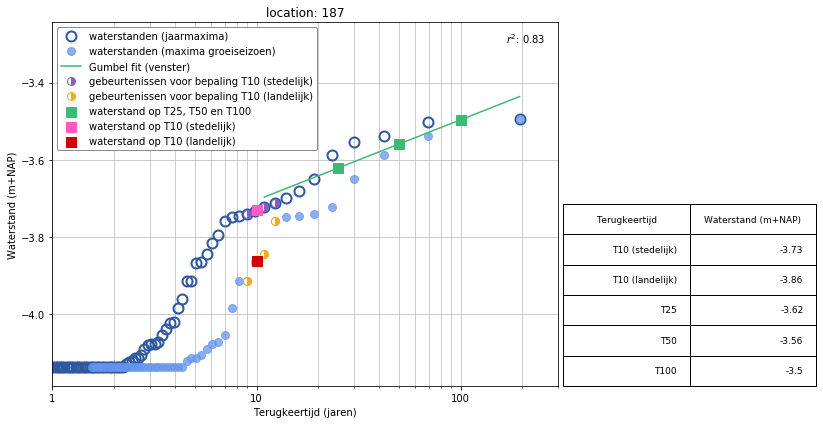

In [14]:
hkv.waterlevelstat.PlotFiguur(ws)

Ook is het mogelijk om de tabellen terug te krijgen als met de daarbij behorende waarden voor de verschillende terugkeertijden en via welke methode en voor welk seizoen deze zijn afgeleid. De functie `schrijfTabellen()` retourneerd twee tabellen welke we hier declareren binnen `df1` en `df2`.

In [15]:
df1, df2 = hkv.waterlevelstat.SchrijfTabellen(ws, 'nodeID')

De tabellen bevatten de volgende informatie

In [16]:
df1

,nodeID,H,T,seizoen,methode
0,187,-3.731,10,geheel jaar,gewogen gemiddelde
1,187,-3.863,10,alleen zomer,gewogen gemiddelde
2,187,-3.802,10,alleen zomer,Gumbel fit
3,187,-3.705,10,geheel jaar,Gumbel fit
4,187,-3.622,25,geheel jaar,Gumbel fit
5,187,-3.559,50,geheel jaar,Gumbel fit
6,187,-3.496,100,geheel jaar,Gumbel fit


en

In [17]:
df2

,nodeID,T10_LANDELIJK,T10_STEDELIJK,T25,T50,T100,r^2,a,b
0,187,-3.863,-3.731,-3.622,-3.559,-3.496,0.833,0.091,-3.913


Al het bovenstaande kan ook automatsich weggeschreven worden naar de output folder. Binnen de output folder moet een `png` folder aanwezig zijn wanneer ook de afgeleide figuren weggeschreven dienen te worden.

In [18]:
out_folder = r'output_data\waterstand-statistiek'

In [19]:
hkv.waterlevelstat.EnsembleRunner(
    out_folder=out_folder,
    his_file=his_file,
    shp_file=shp_file,
    shp_key='nodeID',
    parameter=parameters[0],
    startMMdd=(5, 15),
    endMMdd=(10, 15),
    vensterArray=[0, 10],
    GumbelT=[10, 25, 50, 100],
    TOI=10,
    draw_plot=True,
    write_table=True)

read his-file
read shp-file
create png-file

save csv-file
save shp-file
done


Waarbij de tabel soortgelijk aan `df1` nu is opgeslagen als `output-data\waterstand-statistiek_output_1.csv` en de tabel `df2` nu is gejoined met de `dbf`-tabel en weggeschreven is als nieuw een nieuw shp-file getiteld `output-data\waterstand-statistiek_output_2.shp`. 

De figuren zijn weggeschreven binnen de `output-data\png` folder waarbij bovenstaand figuur opgeslagen is onder `output-data\png\waterstandstatistiek_loc_CFBerg_I_o.png`